<a href="https://colab.research.google.com/github/olga-yu/ML_models_for_efficient_classroom_usage3/blob/master/ARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-17-e73a2b2a29bd>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time_Minutes'] = pd.to_datetime(df['Time']).dt.hour * 60 + pd.to_datetime(df['Time']).dt.minute
<ipython-input-17-e73a2b2a29bd>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time_Minutes'] = pd.to_datetime(df['Time']).dt.hour * 60 + pd.to_datetime(df['Time']).dt.minute


ADF Statistic: -36.757386
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


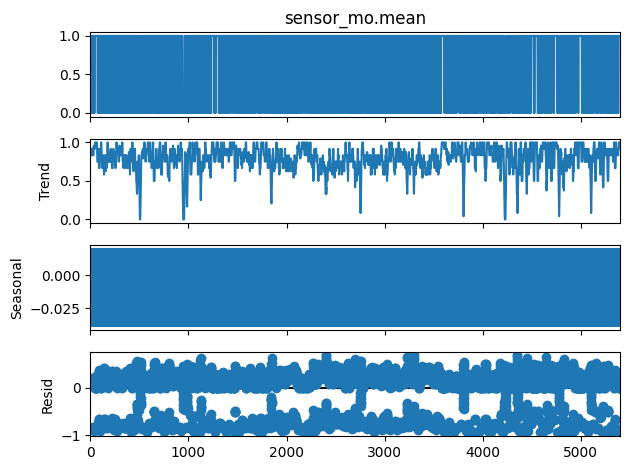

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test RMSE: 0.413
Test MAE: 0.284
Test MSE: 0.170
Test R^2: -0.027


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load dataset (replace with actual filename)
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/processed_motionData2025_3.csv")

# Convert Time to numeric (minutes)
df['Time_Minutes'] = pd.to_datetime(df['Time']).dt.hour * 60 + pd.to_datetime(df['Time']).dt.minute
df = df.drop(columns=['Date', 'Time'])

# Select target time series variable
time_series = df["sensor_mo.mean"]

# Define exogenous variables (ensure they are numeric and properly formatted)
exog_vars = df[['StudentID', 'TimePeriod', 'date-year', 'date-month', 'date-day', 'Season', 'Semester', 'Weekday', 'Time_Minutes']]
exog_vars = pd.get_dummies(exog_vars, drop_first=True)  # One-hot encoding

# 1. Stationarity Check (Augmented Dickey-Fuller Test)
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print("ADF Statistic: %f" % result[0])
    print("p-value: %f" % result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print("\t%s: %.3f" % (key, value))

check_stationarity(time_series)

# 2. Time Series Decomposition
decomposition = seasonal_decompose(time_series, model='additive', period=12)
decomposition.plot()
plt.show()

# 3. Train-Test Split
train_size = int(0.8 * len(time_series))
train_data, test_data = time_series[:train_size], time_series[train_size:]
exog_train, exog_test = exog_vars[:train_size], exog_vars[train_size:]

# 4. Fit ARIMAX Model (SARIMAX with exogenous variables)
model = SARIMAX(train_data, exog=exog_train, order=(5, 0, 5))  # Adjust
model_fit = model.fit()
# 5. Make Predictions
predictions = model_fit.predict(start=len(train_data), end=len(time_series)-1, exog=exog_test)

rmse = np.sqrt(mean_squared_error(test_data, predictions))
mae = mean_absolute_error(test_data, predictions)
mse = mean_squared_error(test_data, predictions)
r2 = r2_score(test_data, predictions)

print("Test RMSE: %.3f" % rmse)
print("Test MAE: %.3f" % mae)
print("Test MSE: %.3f" % mse)
print("Test R^2: %.3f" % r2)